# whizzle model v5 retrain - preference

In [1]:
import os
import pandas as pd
import numpy as np
from time import time
from tqdm.notebook import tqdm
import random
import pickle

from scipy.sparse import coo_matrix, csr_matrix

from lightfm.cross_validation import random_train_test_split
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k, reciprocal_rank

from hyperopt import fmin, hp, tpe, Trials

from sklearn.base import clone

## Normalization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass

C:\Users\SSAFY\anaconda3\envs\mini-project\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
item_features = pd.read_csv("dataset/item_features.csv", index_col=0, encoding="UTF-8")
user_features = pd.read_csv("dataset/user_features.csv", index_col=0, encoding="UTF-8")
train_rating = pd.read_csv("dataset/train_rating.csv", index_col=0, encoding="UTF-8")
test_rating = pd.read_csv("dataset/test_rating.csv", index_col=0, encoding="UTF-8")
whisky = pd.read_csv("dataset/whisky.csv", index_col=0, encoding="UTF-8")

In [3]:
class LightFMResizable(LightFM):
    """A LightFM that resizes the model to accomodate new users,
    items, and features"""

    def fit_partial(
        self,
        interactions,
        user_features=None,
        item_features=None,
        sample_weight=None,
        epochs=1,
        num_threads=1,
        verbose=False,
    ):
        try:
            self._check_initialized()
            self._resize(interactions, user_features, item_features)
        except ValueError:
            # This is the first call so just fit without resizing
            pass

        super().fit_partial(
            interactions,
            user_features,
            item_features,
            sample_weight,
            epochs,
            num_threads,
            verbose,
        )

        return self

    def _resize(self, interactions, user_features=None, item_features=None):
        """Resizes the model to accommodate new users/items/features"""

        no_components = self.no_components
        no_user_features, no_item_features = interactions.shape  # default

        if hasattr(user_features, "shape"):
            no_user_features = user_features.shape[-1]
        if hasattr(item_features, "shape"):
            no_item_features = item_features.shape[-1]

        if (
            no_user_features == self.user_embeddings.shape[0]
            and no_item_features == self.item_embeddings.shape[0]
        ):
            return self

        new_model = clone(self)
        new_model._initialize(no_components, no_item_features, no_user_features)

        # update all attributes from self._check_initialized
        for attr in (
            "item_embeddings",
            "item_embedding_gradients",
            "item_embedding_momentum",
            "item_biases",
            "item_bias_gradients",
            "item_bias_momentum",
            "user_embeddings",
            "user_embedding_gradients",
            "user_embedding_momentum",
            "user_biases",
            "user_bias_gradients",
            "user_bias_momentum",
        ):
            # extend attribute matrices with new rows/cols from
            # freshly initialized model with right shape
            old_array = getattr(self, attr)
            old_slice = [slice(None, i) for i in old_array.shape]
            new_array = getattr(new_model, attr)
            new_array[tuple(old_slice)] = old_array
            setattr(self, attr, new_array)

        return self

In [4]:
item_features

,whisky_id,category,price_tier,abv,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0,0.000,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000
1,1,1,5,0.260,0.30,0.85,0.50,0.30,0.20,0.8,0.80,0.85,0.166667,0.20,0.25,0.85,0.526316
2,2,12,4,0.260,0.40,0.30,0.40,0.20,0.40,0.7,0.80,0.70,0.444444,0.50,0.50,0.70,0.210526
3,3,5,5,0.542,0.15,0.00,0.20,0.00,0.15,0.8,0.90,0.85,0.055556,0.30,0.25,0.35,0.000000
4,4,5,4,0.569,0.40,0.00,0.65,0.50,0.20,0.6,0.60,0.45,0.000000,0.60,0.60,0.45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,8,1,0.260,0.35,0.00,0.20,0.00,0.00,0.4,0.55,0.85,0.000000,0.25,0.10,0.10,0.000000
3532,3532,2,1,0.200,0.00,0.00,0.40,0.20,0.00,0.3,0.00,1.00,0.000000,1.00,0.00,0.60,0.105263
3533,3533,0,3,0.240,0.90,0.10,0.10,0.10,0.40,0.1,0.10,0.90,0.000000,0.50,0.20,0.30,0.105263
3534,3534,9,2,0.290,0.00,0.00,0.10,1.00,0.80,0.0,0.00,0.40,0.000000,0.20,0.00,0.00,0.000000


In [5]:
item_features = item_features[["whisky_id", "price_tier"]+item_features.columns.tolist()[4:]]
item_features

,whisky_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,0,0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000
1,1,5,0.30,0.85,0.50,0.30,0.20,0.8,0.80,0.85,0.166667,0.20,0.25,0.85,0.526316
2,2,4,0.40,0.30,0.40,0.20,0.40,0.7,0.80,0.70,0.444444,0.50,0.50,0.70,0.210526
3,3,5,0.15,0.00,0.20,0.00,0.15,0.8,0.90,0.85,0.055556,0.30,0.25,0.35,0.000000
4,4,4,0.40,0.00,0.65,0.50,0.20,0.6,0.60,0.45,0.000000,0.60,0.60,0.45,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3531,3531,1,0.35,0.00,0.20,0.00,0.00,0.4,0.55,0.85,0.000000,0.25,0.10,0.10,0.000000
3532,3532,1,0.00,0.00,0.40,0.20,0.00,0.3,0.00,1.00,0.000000,1.00,0.00,0.60,0.105263
3533,3533,3,0.90,0.10,0.10,0.10,0.40,0.1,0.10,0.90,0.000000,0.50,0.20,0.30,0.105263
3534,3534,2,0.00,0.00,0.10,1.00,0.80,0.0,0.00,0.40,0.000000,0.20,0.00,0.00,0.000000


In [6]:
def show_comparison_with_my_prefer(preference, result):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    print(result)

    for i, ax in enumerate(axes.flat):
        
        sns.lineplot(data=preference.iloc[0, 2:], ax=ax)
        sns.lineplot(data=item_features.iloc[result[i]][item_features.columns.tolist()[2:]], ax=ax)
        
        ax.set_title("No Name" if result[i] == 0 else whisky['name'][result[i]], fontsize=12)
        ax.set_xlabel('Flavor Profile', fontsize=10)
        ax.set_ylabel('Intensity', fontsize=10)
        ax.set_ylim([0, 1])
        
        # 가격 범위 추가
        pref_price_tier = preference.iloc[0]['price_tier']
        item_price_tier = item_features['price_tier'][result[i]]
        ax.text(0.5, 0.9, f'Preference: {pref_price_tier}', transform=ax.transAxes, ha='center')
        ax.text(0.5, 0.8, f'Whisky: {item_price_tier}', transform=ax.transAxes, ha='center')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
@dataclass
class Preference:
        user_id: int
        price_tier: int
        smoky: float
        peaty: float
        spicy: float
        herbal: float
        oily: float
        body: float
        rich: float
        sweet: float  
        salty: float
        vanilla: float
        tart: float
        floral: float
        fruity: float

In [8]:
@dataclass
class Rating:
    user_id: int
    whisky_id: int
    rating: int

In [9]:
preferences = [
     Preference(-119512, 2,
 0.5,
 0.4,
 0.3,
 0.1,
 0.2,
 0.59,
 0.6,
 0.5,
 0.3333333333333333,
 0.4,
 0.2,
 0.6,
 0.2105263157894736),
    Preference(1, 2,
 0.1,
 0.0,
 0.5,
 0.5,
 0.3,
 0.6,
 0.6,
 0.7000000000000001,
 0.2222222222222222,
 0.5,
 0.5,
 0.8,
 0.2105263157894736),
    Preference(
        2, 4,
 0.2,
 0.0,
 0.4,
 0.1,
 0.3,
 0.8,
 0.8,
 0.8,
 0.0,
 0.7000000000000001,
 0.4,
 0.5,
 0.1052631578947368
    ),
    Preference(3, 
               4,
 0.5,
 0.5,
 0.4,
 0.2,
 0.5,
 0.6,
 0.6,
 0.5,
 0.3333333333333333,
 0.3,
 0.4,
 0.6,
 0.8421052631578947
    ),
    Preference(4,
               2,
 0.2,
 0.0,
 0.5,
 0.3,
 0.4,
 0.6,
 0.6,
 0.7000000000000001,
 0.0,
 0.4,
 0.4,
 0.7000000000000001,
 0.2105263157894736
    ),
    Preference(5,
               4,
 0.6,
 0.8,
 0.4,
 0.4,
 0.4,
 0.7000000000000001,
 0.4,
 0.6,
 0.4444444444444445,
 0.3,
 0.5,
 0.6,
 0.2105263157894736
              )
]


# preferences = [
#      Preference(-119512, 2,
#  0.5,
#  0.4,
#  0.3,
#  0.1,
#  0.2,
#  0.59,
#  0.6,
#  0.5,
#  0.3333333333333333,
#  0.4,
#  0.2,
#  0.6,
#  0.2105263157894736)
#     for i in range(500000)
# ]

In [10]:
new_ratings = [
    Rating(1,354,9),
    Rating(1,651,3),
    Rating(1,1,10),
    Rating(1,95,8),
    Rating(1,1111,0),
    Rating(2,123,10),
    Rating(2,456,8),
    Rating(2,94,6),
    Rating(3,95,9),
    Rating(3,3533,4),
    Rating(4,1111,5),
    Rating(4,951,6),
    Rating(3,664,7)
]

In [11]:
origin_model = pickle.load(open("model/model_user_item_price_flavor.pkl", "rb"))
origin_dataset = pickle.load(open("model/dataset_user_item_price_flavor.pkl", "rb"))

## 기존 모델 정확도 테스트

In [12]:
%time test_rating_source = list(zip(test_rating['user_id'], test_rating['whisky_id'], test_rating['rating']))
test_interactions, _ = origin_dataset.build_interactions(test_rating_source)

CPU times: total: 31.2 ms
Wall time: 46.3 ms


In [13]:
def make_source(data):
    source = []
    for row in data.itertuples(index=False):
        meta = {feat: value for feat, value in zip(data.columns[1:], row[1:])}
        source.append((row[0], meta))
    return source

In [14]:
%time item_source = make_source(item_features[["whisky_id","price_tier"] + item_features.columns.tolist()[4:]])

CPU times: total: 0 ns
Wall time: 21 ms


In [15]:
item_source

[(0,
  {'price_tier': 0,
   'spicy': 0.0,
   'herbal': 0.0,
   'oily': 0.0,
   'body': 0.0,
   'rich': 0.0,
   'sweet': 0.0,
   'salty': 0.0,
   'vanilla': 0.0,
   'tart': 0.0,
   'fruity': 0.0,
   'floral': 0.0}),
 (1,
  {'price_tier': 5,
   'spicy': 0.5,
   'herbal': 0.3,
   'oily': 0.2,
   'body': 0.8,
   'rich': 0.8,
   'sweet': 0.85,
   'salty': 0.1666666666666666,
   'vanilla': 0.2,
   'tart': 0.25,
   'fruity': 0.85,
   'floral': 0.5263157894736842}),
 (2,
  {'price_tier': 4,
   'spicy': 0.4,
   'herbal': 0.2,
   'oily': 0.4,
   'body': 0.7000000000000001,
   'rich': 0.8,
   'sweet': 0.7000000000000001,
   'salty': 0.4444444444444445,
   'vanilla': 0.5,
   'tart': 0.5,
   'fruity': 0.7000000000000001,
   'floral': 0.2105263157894736}),
 (3,
  {'price_tier': 5,
   'spicy': 0.2,
   'herbal': 0.0,
   'oily': 0.15,
   'body': 0.8,
   'rich': 0.9,
   'sweet': 0.85,
   'salty': 0.0555555555555555,
   'vanilla': 0.3,
   'tart': 0.25,
   'fruity': 0.35,
   'floral': 0.0}),
 (4,
  {'pric

In [16]:
%time user_source = make_source(user_features)

CPU times: total: 234 ms
Wall time: 756 ms


In [17]:
user_source

[(0,
  {'price_tier': 0,
   'smoky': 0.0,
   'peaty': 0.0,
   'spicy': 0.0,
   'herbal': 0.0,
   'oily': 0.0,
   'body': 0.0,
   'rich': 0.0,
   'sweet': 0.0,
   'salty': 0.0,
   'vanilla': 0.0,
   'tart': 0.0,
   'fruity': 0.0,
   'floral': 0.0}),
 (1,
  {'price_tier': 5,
   'smoky': 0.3,
   'peaty': 0.85,
   'spicy': 0.5,
   'herbal': 0.3,
   'oily': 0.2,
   'body': 0.8,
   'rich': 0.8,
   'sweet': 0.85,
   'salty': 0.1666666666666666,
   'vanilla': 0.2,
   'tart': 0.25,
   'fruity': 0.85,
   'floral': 0.5263157894736842}),
 (2,
  {'price_tier': 5,
   'smoky': 0.3,
   'peaty': 0.0,
   'spicy': 0.4,
   'herbal': 0.1,
   'oily': 0.3,
   'body': 0.7000000000000001,
   'rich': 0.8,
   'sweet': 0.8,
   'salty': 0.1111111111111111,
   'vanilla': 0.6,
   'tart': 0.2,
   'fruity': 0.9,
   'floral': 0.1052631578947368}),
 (3,
  {'price_tier': 4,
   'smoky': 0.3,
   'peaty': 0.2,
   'spicy': 0.6,
   'herbal': 0.2,
   'oily': 0.4,
   'body': 0.6,
   'rich': 0.6,
   'sweet': 0.7000000000000001,


In [18]:
item_meta = origin_dataset.build_item_features(item_source, normalize=False)
user_meta = origin_dataset.build_user_features(user_source, normalize=False)

## Test Result
CPU times: total: 42.6 s        Wall time: 1min 34s        Train precision: 0.03699642 <br>
CPU times: total: 42.3 s        Wall time: 1min 34s        Test precision:  0.15505537 <br>
CPU times: total: 52.6 s        Wall time: 1min 39s        Test AUC Score : 0.92622846 <br>
CPU times: total: 54.3 s        Wall time: 1min 43s        MRR 0.13413700

## 기존 사용자 rating 변경 반영 & 선호도 변경 반영

## preference 변경

In [19]:
def make_new_preference(my, num):
    return pd.DataFrame([[my] + user_features.iloc[num].tolist()[1:]], columns=user_features.columns)

In [25]:
my_prefer = make_new_preference(119511, 119511)
my_prefer

,user_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,119511,1.0,0.0,0.0,0.4,0.2,0.0,0.3,0.0,1.0,0.0,1.0,0.0,0.6,0.105263


In [26]:
my_prefer_meta = make_source(my_prefer)
my_prefer_meta = origin_dataset.build_user_features(my_prefer_meta)
my_prefer_meta

<119516x119530 sparse matrix of type '<class 'numpy.float32'>'
	with 119530 stored elements in Compressed Sparse Row format>

In [27]:
u_i_scores = origin_model.predict(user_ids=119511, item_ids=item_features.whisky_id.unique(), user_features=my_prefer_meta, item_features=item_meta)
u_i_scores

array([-11.397302, -11.528841, -11.455761, ..., -11.544526, -11.479019,
       -11.431813], dtype=float32)

In [28]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

[2469, 1645, 3350, 3293, 2861, 818, 1995, 3026, 3007]

In [83]:
preference = pd.DataFrame([user_features.iloc[119511]], columns=user_features.columns)

In [84]:
preference

,user_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
119511,119511.0,1.0,0.0,0.0,0.4,0.2,0.0,0.3,0.0,1.0,0.0,1.0,0.0,0.6,0.105263


[2469, 1645, 3350, 3293, 2861, 818, 1995, 3026, 3007]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


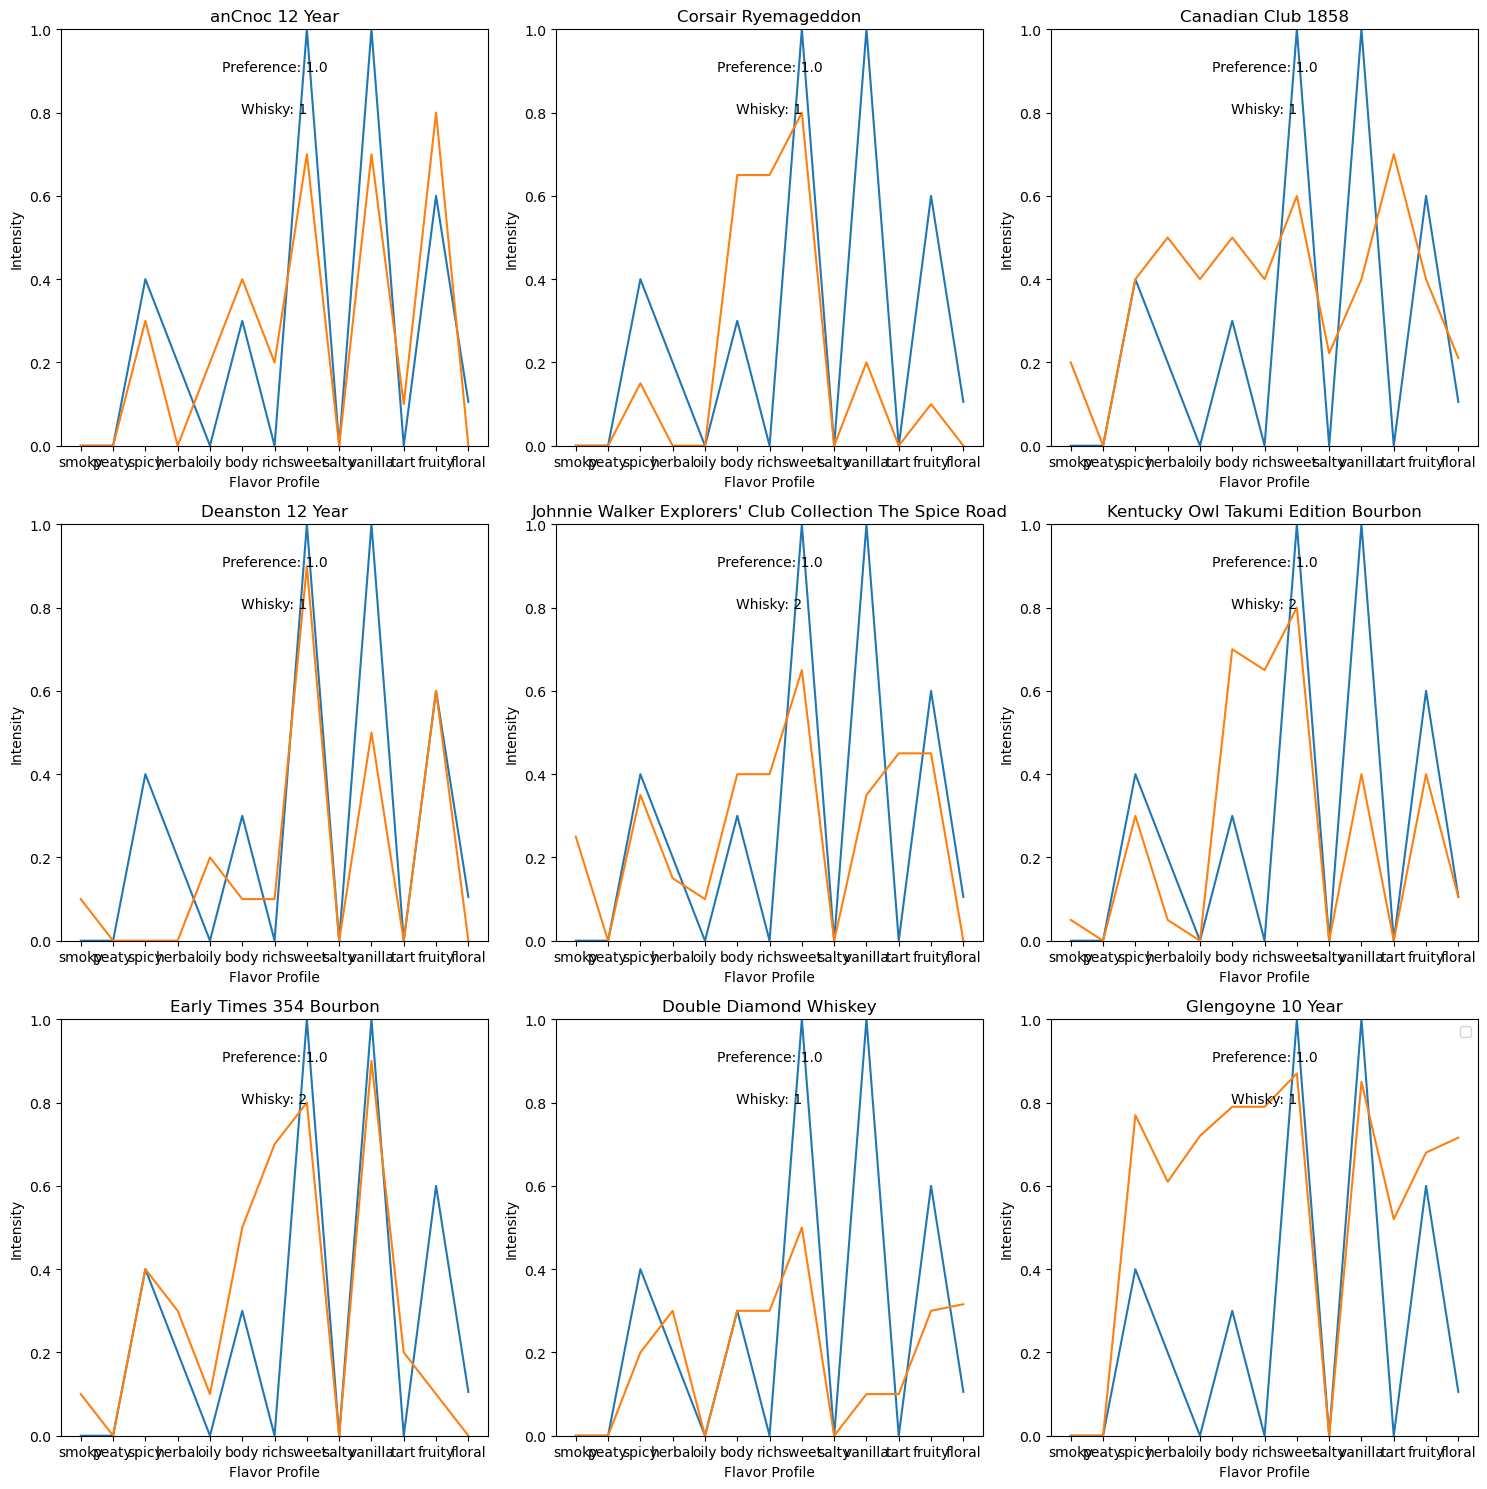

In [29]:
show_comparison_with_my_prefer(my_prefer, u_i_result)

## 기존 사용자 - 새로운 취향 추천
🌟 재학습없이 단지 취향 정보 변경

In [30]:
user_features.iloc[119511]

user_id       119511.000000
price_tier         1.000000
smoky              0.000000
peaty              0.000000
spicy              0.400000
herbal             0.200000
oily               0.000000
body               0.300000
rich               0.000000
sweet              1.000000
salty              0.000000
vanilla            1.000000
tart               0.000000
fruity             0.600000
floral             0.105263
Name: 119511, dtype: float64

In [31]:
user_features.iloc[65120]

user_id       65120.000000
price_tier        2.000000
smoky             0.200000
peaty             0.000000
spicy             0.300000
herbal            0.200000
oily              0.500000
body              0.600000
rich              0.700000
sweet             0.800000
salty             0.111111
vanilla           0.300000
tart              0.200000
fruity            0.700000
floral            0.315789
Name: 65120, dtype: float64

In [32]:
preference = make_new_preference(119511, 65120)
preference

,user_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,119511,2.0,0.2,0.0,0.3,0.2,0.5,0.6,0.7,0.8,0.111111,0.3,0.2,0.7,0.315789


In [33]:
prefer_source = make_source(preference)
prefer_source

[(119511,
  {'price_tier': 2.0,
   'smoky': 0.2,
   'peaty': 0.0,
   'spicy': 0.3,
   'herbal': 0.2,
   'oily': 0.5,
   'body': 0.6,
   'rich': 0.7000000000000001,
   'sweet': 0.8,
   'salty': 0.1111111111111111,
   'vanilla': 0.3,
   'tart': 0.2,
   'fruity': 0.7000000000000001,
   'floral': 0.3157894736842105})]

In [34]:
prefer_meta = origin_dataset.build_user_features(prefer_source)
prefer_meta

<119516x119530 sparse matrix of type '<class 'numpy.float32'>'
	with 119530 stored elements in Compressed Sparse Row format>

In [35]:
scores = origin_model.predict(user_ids=119511, item_ids=item_features.whisky_id.unique(), user_features=prefer_meta, item_features=item_meta)
scores

array([-11.947663, -12.026471, -11.955168, ..., -12.072054, -12.022602,
       -11.978214], dtype=float32)

In [36]:
result = np.argsort(-scores).tolist()[:9]
result

[2469, 1645, 3350, 2861, 818, 3293, 3224, 1995, 3026]

In [37]:
preference

,user_id,price_tier,smoky,peaty,spicy,herbal,oily,body,rich,sweet,salty,vanilla,tart,fruity,floral
0,119511,2.0,0.2,0.0,0.3,0.2,0.5,0.6,0.7,0.8,0.111111,0.3,0.2,0.7,0.315789


[2469, 1645, 3350, 3293, 2861, 818, 1995, 3026, 3007]

[2469, 1645, 3350, 2861, 818, 3293, 3224, 1995, 3026]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


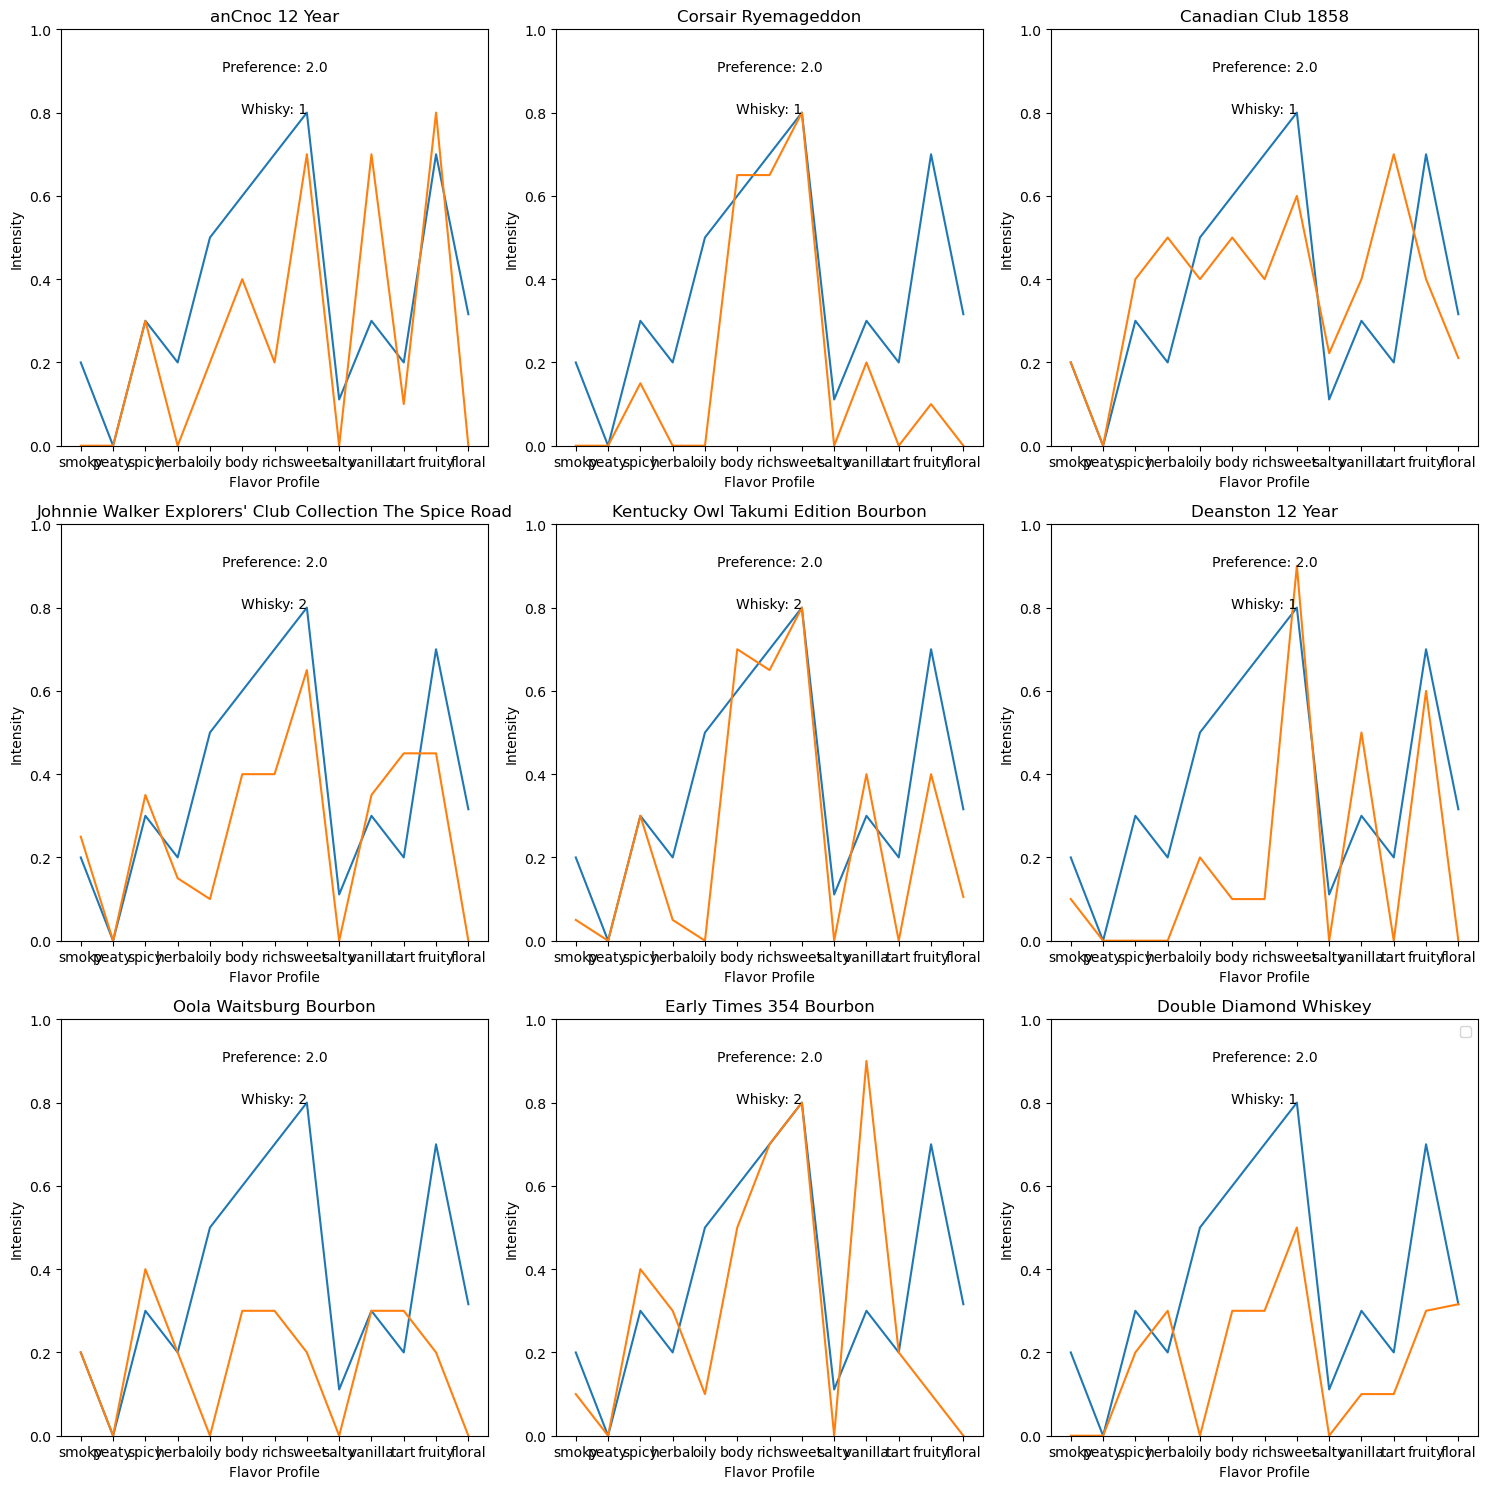

In [38]:
show_comparison_with_my_prefer(preference, result)

## 선호 취향 재학습시킨 후 똑같은 로직 수행해보자
---
- retrain_model1 : 바뀐 preference만 전달
- retrain_model2 : 모든 user_features 전달

In [95]:
retrain_model1 = pickle.load(open("model/model_user_item_price_flavor.pkl", "rb"))
retrain_model2 = pickle.load(open("model/model_user_item_price_flavor.pkl", "rb"))

### retrain_model1 : 바뀐 preference만 전달

In [40]:
%time rating_source = list(zip(train_rating['user_id'], train_rating['whisky_id'], train_rating['rating']))
train_interactions, train_weights = origin_dataset.build_interactions(rating_source)

CPU times: total: 78.1 ms
Wall time: 177 ms


In [41]:
prefer_meta

<119516x119530 sparse matrix of type '<class 'numpy.float32'>'
	with 119530 stored elements in Compressed Sparse Row format>

In [46]:
my_rating = train_rating.loc[train_rating.user_id == 119511]
update_rating_source = list(zip(my_rating['user_id'], my_rating['whisky_id'], my_rating['rating']))
update_interactions, update_weights = origin_dataset.build_interactions(update_rating_source)

In [89]:
%time modified_model1 = origin_model.fit_partial(interactions=update_interactions, sample_weight=update_weights, user_features=prefer_meta, item_features=item_meta, epochs=2, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 62.53it/s]

CPU times: total: 31.2 ms
Wall time: 35 ms


In [93]:
%time test_precision = precision_at_k(modified_model1, test_interactions, user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_recall = recall_at_k(modified_model1, test_interactions,  user_features=user_meta, item_features=item_meta, k=9).mean()
%time test_auc = auc_score(modified_model1, test_interactions, user_features=user_meta, item_features=item_meta).mean()
%time test_rep = reciprocal_rank(modified_model1, test_interactions=test_interactions, user_features=user_meta, item_features=item_meta).mean()

print("Train precision: %.8f" % test_precision)
print("Test precision: %.8f" % test_recall)
print("Test AUC Score : %.8f" % test_auc)
print("Test MRR : %.8f" % test_rep)

CPU times: total: 1min 4s
Wall time: 1min 32s
CPU times: total: 1min 6s
Wall time: 1min 33s
CPU times: total: 1min 5s
Wall time: 1min 33s
CPU times: total: 1min 5s
Wall time: 1min 33s
Train precision: 0.03686910
Test precision: 0.15448570
Test AUC Score : 0.92620438
Test MRR : 0.13389249


In [97]:
u_i_scores = modified_model1.predict(user_ids=119511, item_ids=item_features.whisky_id.unique(), user_features=prefer_meta, item_features=item_meta)
u_i_scores

array([-11.952879, -12.044889, -11.975681, ..., -12.082034, -12.028895,
       -11.984581], dtype=float32)

In [98]:
u_i_result = np.argsort(-u_i_scores).tolist()[:9]
u_i_result

[2469, 1645, 2861, 3293, 818, 3350, 3224, 1995, 3026]

[610, 1369, 2679, 3350, 2255, 2242, 95, 2243, 2477]

In [100]:
[2469, 1645, 3350, 2861, 818, 3293, 3224, 1995, 3026]

[2469, 1645, 3350, 2861, 818, 3293, 3224, 1995, 3026]

[2469, 1645, 2861, 3293, 818, 3350, 3224, 1995, 3026]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


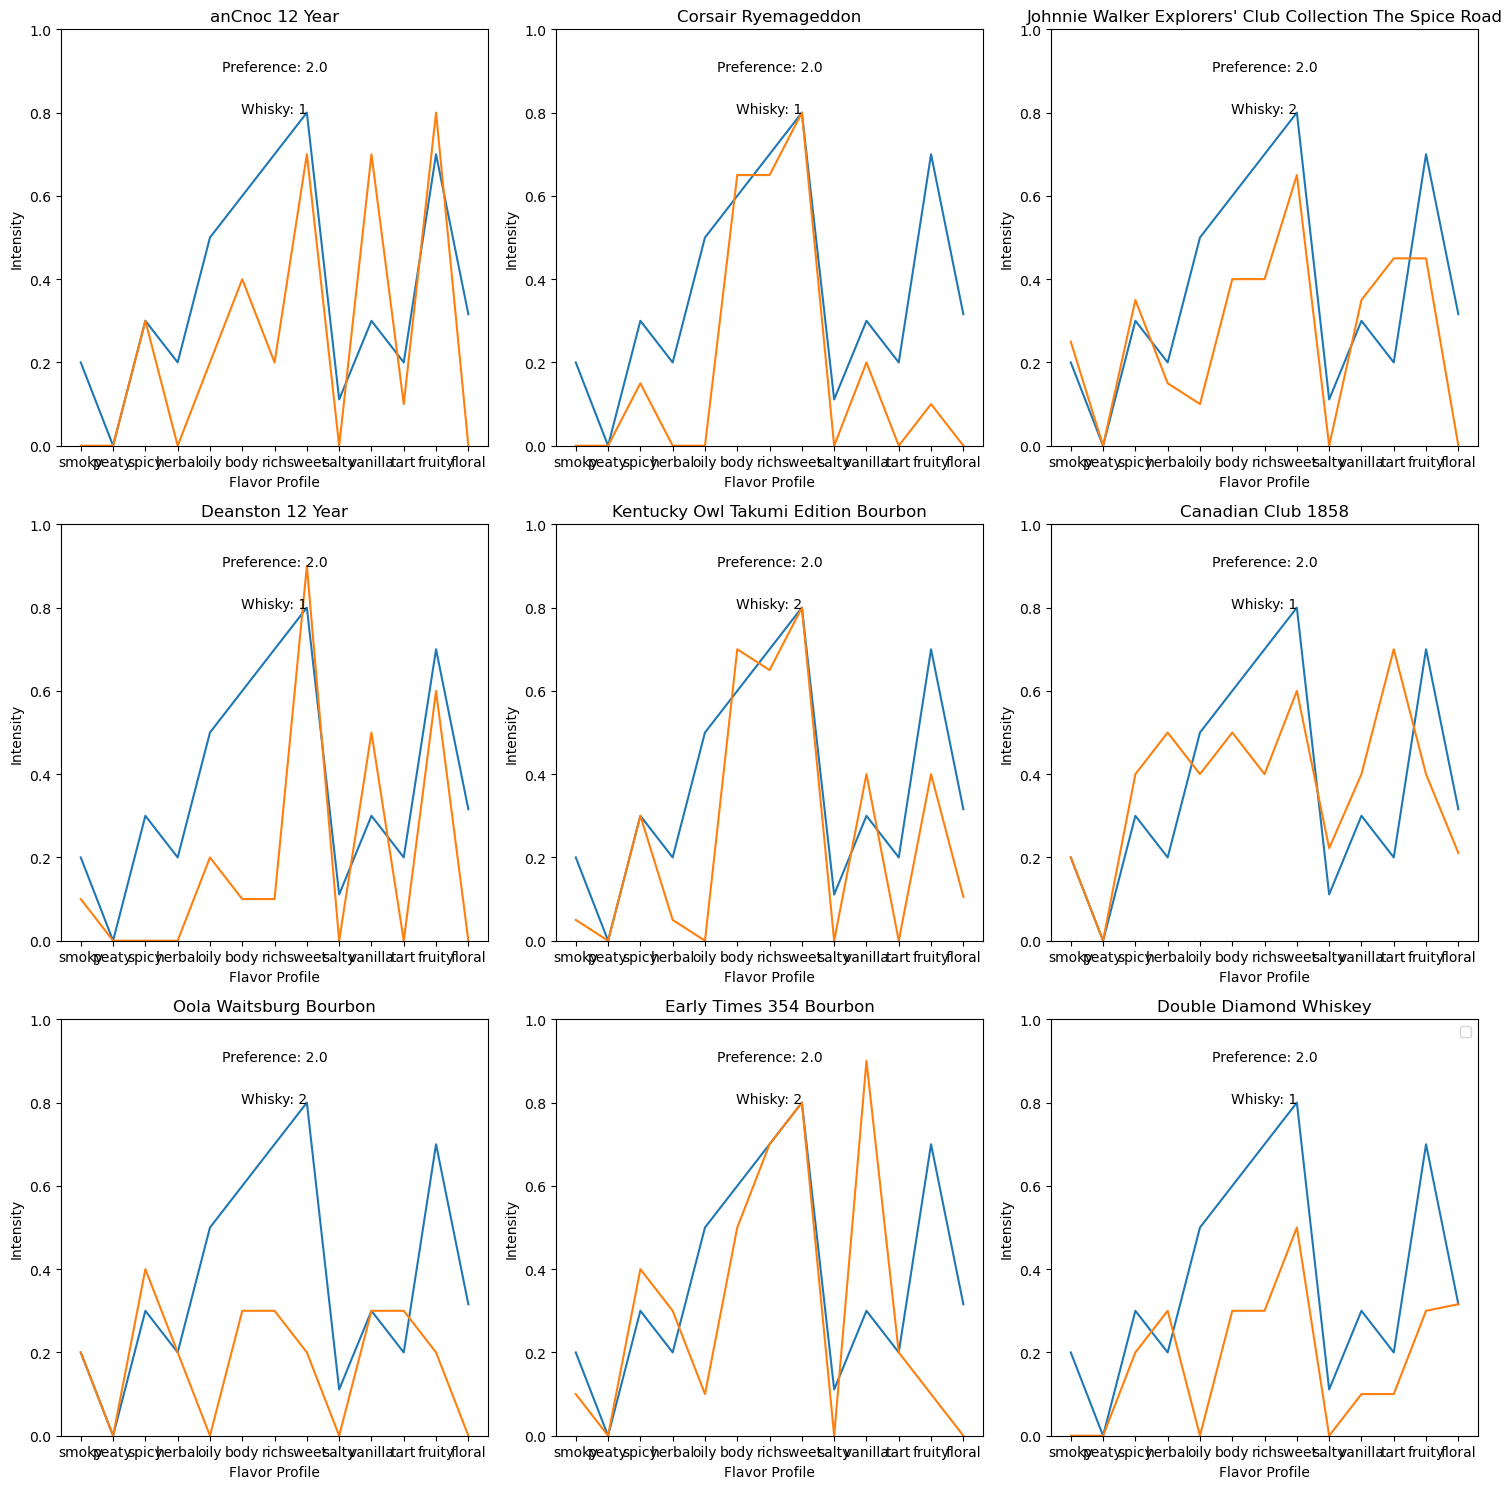

In [99]:
show_comparison_with_my_prefer(preference, u_i_result)